In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings("ignore")

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(A, b, test = False):
    positive_indices = np.where(b == 1)[0]
    negative_indices = np.where(b == 0)[0]
    
    plt.scatter(A[positive_indices, 0], A[positive_indices, 1], marker='x', c= 'yellow' if test else 'green')
    plt.scatter(A[negative_indices, 0], A[negative_indices, 1], marker='+', c= 'blue' if test else 'red')

In [4]:
class NeuralNet:
    
    def __init__(self, hidden_layer_sizes=(10, ), normalize=True, learning_rate=0.01, max_iter=30000, batch_size=32, momentum=0, epsilon=1e-10, random_state=42):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.normalize = normalize
        self.momentum = momentum
        self.batch_size = batch_size
        self.epsilon = epsilon
        np.random.seed(random_state)

    def __normalize(self, X, mean=None, std=None):
        if mean is None or std is None:
            mean = np.zeros([X.shape[0], 1])
            std  = np.ones([X.shape[0], 1])

            for i in range(X.shape[0]):
                if (np.std(X[:, i]) != 0):
                    mean[i] = np.mean(X[:, i])
                    std[i] = np.std(X[:, i])
                
        X_new = (X - mean) / std
        return X_new, mean, std
    

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __sigmoid_derivative(self, Z):
        z = self.__sigmoid(Z)
        return np.multiply(z, (1 - z))
    
    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)
    
    def __cross_entropy(self, A, Y):
        return -np.mean(Y.T * np.log(A.T+ 1e-8))
    
    def __initialize_parameters(self, n_x, n_y, hidden_layers):
        W = []
        b = []
        self.VdW = []
        self.Vdb = []
        
        self.parameters = {}
        layers = [n_x] + list(hidden_layers) + [n_y]
        for i in range(1, self.num_layers + 1):
            W.append(np.random.randn(layers[i], layers[i - 1]) / np.sqrt(layers[i - 1]))
            b.append(np.zeros((layers[i], 1)))    
            self.VdW.append(np.zeros((layers[i], layers[i - 1])))
            self.Vdb.append(np.zeros((layers[i], 1)))
        
        self.parameters.update({"W": W, "b": b})
                    
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]
        
        A = []
        Z = []
        
        for i in range(0, self.num_layers - 1):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
        
        Z.append(np.dot(W[-1], A[-1]) + b[-1])
        A.append(self.__stable_softmax(Z[-1])) 
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * self.num_layers
        dA = [None] * self.num_layers
        dZ = [None] * self.num_layers
        db = [None] * self.num_layers
        
        dZ[-1] = A[-1] - Y
        dW[-1] = (1. / m) * np.dot(dZ[-1], A[-2].T)
        db[-1] = (1. / m) * np.sum(dZ[-1], axis = 1, keepdims = True)
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.num_layers-1, 0, -1):
            dZ[i-1] = np.multiply(dA[i], self.__sigmoid_derivative(Z[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True) 
            dA[i-1] = np.dot(W[i-1].T, dZ[i-1])
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def __update_parameters(self, grads, iteration):
        for i in range(self.num_layers):
            W = self.parameters[f"W"]
            b = self.parameters[f"b"]          
            dW = grads[f"dW"]
            db = grads[f"db"]        
            self.VdW[i] = (self.momentum * self.VdW[i] + (1 - self.momentum) * dW[i] / (1 - self.momentum ** (iteration + 1)))
            self.Vdb[i] = (self.momentum * self.Vdb[i] + (1 - self.momentum) * db[i] / (1 - self.momentum ** (iteration + 1)))
            W[i] = W[i] - self.learning_rate * self.VdW[i]
            b[i] = b[i] - self.learning_rate * self.Vdb[i]     
            self.parameters = {"W" : W, "b" : b}
    
    def __create_mini_batches(self, X, Y, batch_size):
        m = X.shape[1]

        if batch_size == -1:
            batch_size = m
            
        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]        
        shuffled_Y = Y[:, permutation]
        mini_batches = []
        n_minibatches = m // batch_size
        
        for i in range(n_minibatches): 
            X_mini = shuffled_X[:, i * batch_size:(i + 1)*batch_size] 
            Y_mini = shuffled_Y[:, i * batch_size:(i + 1)*batch_size] 
            mini_batches.append((X_mini, Y_mini))
        if m % batch_size != 0:
            X_mini = shuffled_X[:, (i+1) * batch_size:m] 
            Y_mini = shuffled_Y[:, (i+1) * batch_size:m] 
            mini_batches.append((X_mini, Y_mini)) 
        return mini_batches
    
    def fit(self, X_vert, Y_vert, print_cost=False, print_by=1000):
        self.num_layers = len(self.hidden_layer_sizes) + 1
        X, Y = X_vert.T, Y_vert.T
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        costs = []    
        m = X.shape[1]
        n_x = X.shape[0]
        n_y = Y.shape[0]   
        self.__initialize_parameters(n_x, n_y, self.hidden_layer_sizes)  
        for i in range(self.max_iter):
            mini_batches = self.__create_mini_batches(X, Y, self.batch_size) 
            for (X_mini, Y_mini) in mini_batches:
                A, cache = self.__forward_propagation(X_mini)
                cost = self.__cross_entropy(A, Y_mini)
                grads = self.__backward_propagation(X_mini, Y_mini, cache)
                self.__update_parameters(grads, i)
            costs.append(cost)
            if print_cost and i % print_by == 0:
                print("{}-th iteration: {}".format(i, cost))
            if i > 1 and abs(costs[-2] - costs[-1]) < self.epsilon:
                break
               
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel(f"Iteration, *{print_by}")
            plt.show()

    def __likehood_func(self, z):
        return z.argmax(axis=1)
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        y_pred = self.__likehood_func(positive_probs)
        return y_pred  
    
    def get_params(self, deep=True):
        return {
                "hidden_layer_sizes": self.hidden_layer_sizes,
                "normalize": self.normalize,
                "learning_rate": self.learning_rate, 
                "max_iter": self.max_iter,
                "batch_size": self.batch_size,
                "momentum": self.momentum
               }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [5]:
zoo = pd.read_csv("zoo.csv")
zoo.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [6]:
zoo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 18 columns):
animal_name    101 non-null object
hair           101 non-null int64
feathers       101 non-null int64
eggs           101 non-null int64
milk           101 non-null int64
airborne       101 non-null int64
aquatic        101 non-null int64
predator       101 non-null int64
toothed        101 non-null int64
backbone       101 non-null int64
breathes       101 non-null int64
venomous       101 non-null int64
fins           101 non-null int64
legs           101 non-null int64
tail           101 non-null int64
domestic       101 non-null int64
catsize        101 non-null int64
class_type     101 non-null int64
dtypes: int64(17), object(1)
memory usage: 14.3+ KB


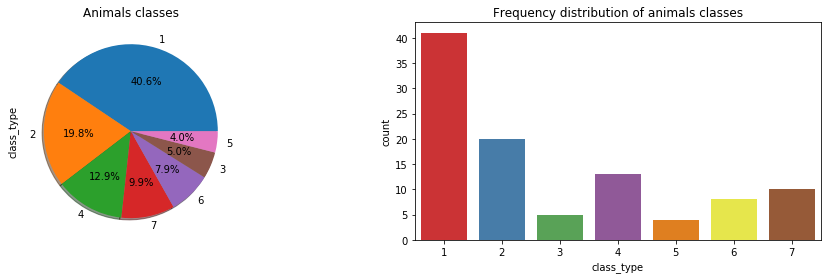

In [7]:
f,ax = plt.subplots(1,2,figsize=(16,4))

ax[0] = zoo['class_type'].value_counts().plot.pie(explode=[0,0,0,0,0,0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Animals classes')
ax[1] = sns.countplot(x="class_type", data=zoo, palette="Set1")
ax[1].set_title("Frequency distribution of animals classes")
plt.show()

In [8]:
X = zoo.iloc[:,:-1]
X.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1


In [9]:
Y = zoo.iloc[:,-1:]
Y.head()

,class_type
0,1
1,1
2,4
3,1
4,1


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print("Training Data has",X_train.shape)
print("Testing Data has",X_test.shape)

Training Data has (70, 17)
Testing Data has (31, 17)


In [11]:
train_name = X_train['animal_name']
test_name = X_test['animal_name']

X_train = X_train.iloc[:,1:]
X_test = X_test.iloc[:,1:]

In [12]:
X_train.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
80,0,0,1,0,0,0,1,1,1,1,0,0,0,1,0,0
91,0,0,1,0,0,0,1,1,1,1,0,0,4,1,0,0
68,1,0,0,1,0,0,1,1,1,1,0,0,4,1,1,1
51,1,0,1,0,1,0,0,0,0,1,0,0,6,0,0,0
27,1,0,0,1,1,0,0,1,1,1,0,0,2,1,0,0


In [13]:
Y_train.head()

,class_type
80,3
91,3
68,1
51,6
27,1


In [14]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
Y_train = Y_train.to_numpy()

# MLPClassifier

In [235]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier().fit(X_train, np.ravel(Y_train))

In [236]:
print(f"Accuracy:  {accuracy_score(Y_test, clf.predict(X_test))}")
print(f"Precision: {precision_score(Y_test, clf.predict(X_test), average='weighted')}")
print(f"Recall:    {recall_score(Y_test, clf.predict(X_test), average='weighted')}")

Accuracy:  0.967741935483871
Precision: 0.9717741935483871
Recall:    0.967741935483871


# GridSearch

In [18]:
from sklearn.model_selection import GridSearchCV
hl_sizes=[(8,),(8, 7)]
activations=['logistic', 'tanh', 'relu']
alphas = np.array([1,0.1,0.001,0])
model = MLPClassifier()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas,hidden_layer_sizes=hl_sizes,activation=activations))

grid.fit(X_train[:70], Y_train[:70])
print(grid)
print('-------------------------------------------------------------------------------------')
print('Best score          :   ',grid.best_score_)
print('Alpha               :   ',grid.best_estimator_.alpha)
print('Hidden_layer_sizes  :   ',grid.best_estimator_.hidden_layer_sizes)
print('Solver              :   ',grid.best_estimator_.solver)
print('Activation          :   ',grid.best_estimator_.activation)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', '

In [20]:
y_test_pred=grid.predict(X_test)
print(classification_report(Y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.92      1.00      0.96        11
           2       0.67      1.00      0.80         6
           3       0.00      0.00      0.00         2
           4       1.00      1.00      1.00         7
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.33      0.50      0.40         2

    accuracy                           0.81        31
   macro avg       0.42      0.50      0.45        31
weighted avg       0.70      0.81      0.75        31



In [21]:
res = [print(f"{key}: {val}") for key, val in grid.best_params_.items()]

activation: tanh
alpha: 0.1
hidden_layer_sizes: (8, 7)
